<a href="https://colab.research.google.com/github/nisaac21/TensorFlow/blob/main/Blackjack_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

In [2]:
env = gym.make('Blackjack-v1')
env.reset()


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


(15, 1, False)

Below is the MonteCarlo implementation for determining the state value function for a blackjack agent that hits on anything below 20. This implementation is an attempt to recreate the graphs on page 94 of Richard Sutton's *Reinforcement Learning* using first-visit MC policy evaluation. 

In [3]:
from collections import defaultdict

def blackjack(episodes=500000, gamma=1):
    '''
        episodes (int) = interactions with environment 
        gamma (int) = learning rate 
    '''

    env = gym.make("Blackjack-v1")
    
    """
        Observation space comes in form
        (player's current sum, # dealer shows, player has ace?)
        last value is 0 or 1
    """
    
    def policy(player_sum):
        if player_sum >= 20:
            return 0
        return 1
        
    V_s = defaultdict(float) # Key: tuple state --> Value: int state value for state, For all state with ace
    # V_sNoAce = defaultdict(float) # Key: tuple state --> Value: int state value for state, For all state without ace 
 
    numVisits = defaultdict(float)

    for episode in range(episodes):

        if(episode % 100000 == 0):
            print(f"Episode: {episode}")
        
        G = 0 # int return for current episode
        
        visited_states = [ ]
        rewards = []
        
        action = policy(env.reset()[0])
        state, reward, done, _ = env.step(action)

        while not (done):
            visited_states.append(state)
            action = policy(state[0])
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            

        for timestep, state in enumerate(reversed(visited_states)):
            G = gamma*G + rewards[timestep]
            for i in range(timestep):
                if visited_states[i] == state:
                    break
            if(V_s.get(state, False)):
                numVisits[state] += 1
                V_s[state] += (1 / numVisits[state]) * (G - V_s[state])
            else:
                numVisits[state] = 1
                V_s[state] = G

    return V_s

In [4]:
V_s = blackjack()

Episode: 0
Episode: 100000
Episode: 200000
Episode: 300000
Episode: 400000


Plotting the state-value function

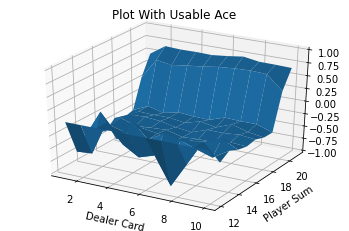

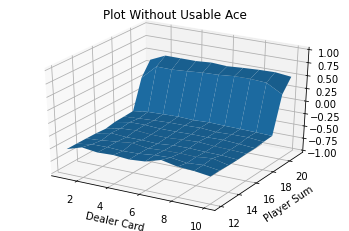

In [5]:
def plot3DGraph(V_s, ace):
    fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})
    v = [] 

    player_sum = np.arange(12, 22, 1)
    dealer_sum = np.arange(1, 11, 1)

    for player in list(player_sum):
        for dealer in list(dealer_sum):
            if(ace):
                v.append(V_s[(player, dealer, 1)])
            else:
                v.append(V_s[(player, dealer, 0)])

    ax.set_zlim3d(-1, 1)

    player_sum, dealer_sum = np.meshgrid(dealer_sum, player_sum)
    ax.plot_surface(X=player_sum, Y=dealer_sum, Z=np.array(v).reshape(player_sum.shape))
    if(ace):
        plt.title("Plot With Usable Ace")
    else:
        plt.title("Plot Without Usable Ace")
    plt.xlabel("Dealer Card")
    plt.ylabel("Player Sum")
    plt.show()

plot3DGraph(V_s, True)
plot3DGraph(V_s, False)

Below is the implementation for a first-visit MC control agent with exploring starts. 

In [11]:
def blackjack2(episodes=1000000, gamma=1):
    '''
        episodes (int) = interactions with environment 
        gamma (int) = learning rate 
    '''
    env = gym.make("Blackjack-v1")
    
    policy = defaultdict(int) # Key: tuple state --> Value: int action (either 0 or 1)
        
    Q_sa = defaultdict(lambda : np.zeros(env.action_space.n)) # Key: tuple state --> Value: [value if stand, value if hit] 
    
    numVisits = defaultdict(lambda : np.zeros(env.action_space.n)) # Key: tuple state --> Value: [num of visits if stand, num of visits if hit]

    V_s = defaultdict(float) # Key: tuple state --> int state value 

    for episode in range(episodes):

        if(episode % 100000 == 0):
            print(f"Episode: {episode}")
        
        G = 0 #int return for current episode
        
        visited_states = [] # List of states as they appear
        actions = [] # List of actions as taken
        rewards = [] # List of rewards 
        
        state = env.reset()
        action = random.choice([0, 1])
        while True:
            visited_states.append(state)
            state, reward, done, _ = env.step(action)
            actions.append(action)
            rewards.append(reward)
            action = policy[state]
            if(done):
                break
            

        for timestep, state in reversed(list(enumerate(visited_states))):
            G = gamma*G + rewards[timestep]
            for i in range(timestep):
                if visited_states[i] == state:
                    break
            
            numVisits[state][actions[timestep]] += 1
            V_s[state] += (1 / sum(numVisits[state][:])) * (G - V_s[state])
            Q_sa[state][actions[timestep]] += (1 / numVisits[state][actions[timestep]]) * (G - Q_sa[state][actions[timestep]])
            policy[state] = np.argmax(Q_sa[state])

    return policy, V_s

In [12]:
policy, V_s = blackjack2()

Episode: 0
Episode: 100000
Episode: 200000
Episode: 300000
Episode: 400000
Episode: 500000
Episode: 600000
Episode: 700000
Episode: 800000
Episode: 900000


Plotting the optimal policy with and without ace with accompanying state value functions. 

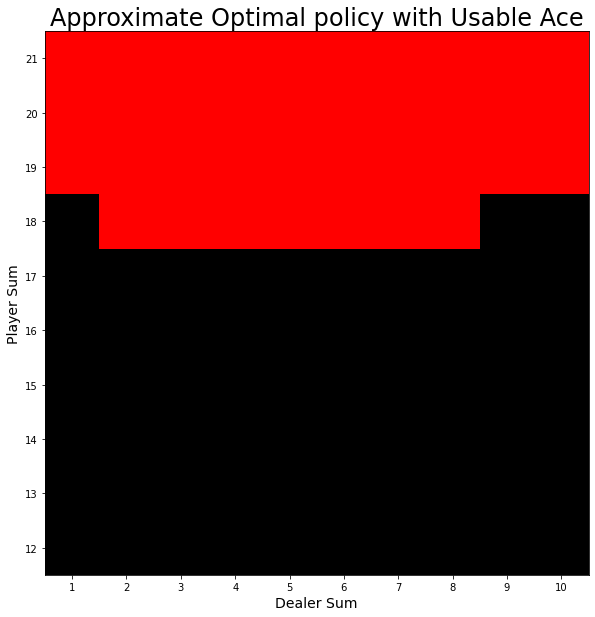

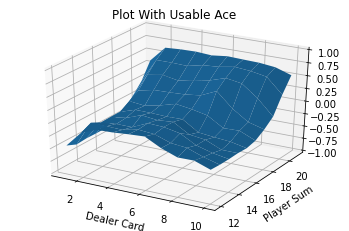

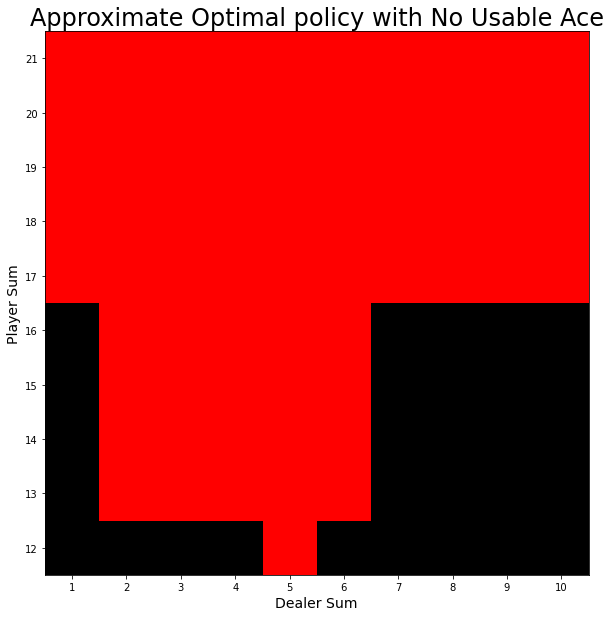

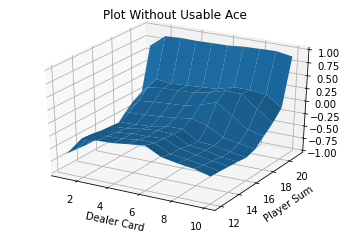

In [13]:
from matplotlib import colors

def plot_policy(policy, ace):
    

    player_sum = np.arange(12, 22, 1)
    dealer_sum = dealer_sum = np.arange(1, 11, 1)

    # create plot values from the policy 
    plot_values = np.zeros([len(player_sum), len(dealer_sum)])

    for dealer in range(1,11):
        for player in range(12,22):
            if ace:
                i = 1
            else:
                i = 0
            plot_values[player-12, dealer-1] = policy[(player, dealer, i)]
    
    # Creating the grid 
    colormap = colors.ListedColormap(["red", "black"])
    plt.figure(figsize= (len(dealer_sum), len(player_sum)))
    plt.imshow(plot_values, cmap=colormap)
    plt.xticks(ticks=[i for i in range(len(dealer_sum))], labels=dealer_sum)
    plt.yticks(ticks=[i for i in range(len(player_sum))], labels = player_sum)
    plt.xlabel("Dealer Sum", size = 14)
    plt.gca().invert_yaxis() 
    plt.ylabel("Player Sum", size = 14)
    if ace:
        plt.title("Approximate Optimal policy with Usable Ace", size = 24)
    else:
        plt.title("Approximate Optimal policy with No Usable Ace", size = 24)
    plt.show()

plot_policy(policy, True)
plot3DGraph(V_s, True)
plot_policy(policy, False)
plot3DGraph(V_s, False)

##Sources

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

https://colab.research.google.com/drive/1IlrlS3bB8t1Gd5Pogol4MIwUxlAjhWOQ#forceEdit=true&sandboxMode=true

